### 계획
1. Import
2. Data Processing (Preprocessing)
    - Data Load
    - Original Signal + Visualization
    - CWT
3. Model Define (Pytorch) + Hyperparameter Tuning
    - LSTM Autoencoder
        * batch_size
        * hidden_size
        * layer_numbers
        * num_epochs
        * learning_rate
4. Training
5. Test

### Import

In [9]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.fft import fft, ifft
import pywt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pywt
import torch.nn.functional as F
from keras.utils import to_categorical
import scipy.signal

### Data Preprocessing

In [3]:
# Data Processing
print("Data Processing")
RPM = 3000
base_path = "5000hz_raw_data/" + str(RPM) + "rpm/"
folders = [
    str(RPM) + "rpm " + "normal data",
    str(RPM) + "rpm " + "carriage damage",
    str(RPM) + "rpm " + "high-speed damage",
    str(RPM) + "rpm " + "lack of lubrication",
    str(RPM) + "rpm " + "oxidation and corrosion",
]
columns = ["motor1_x", "motor1_y", "motor1_z", "sound", "time"]

Data Processing


In [4]:
# 데이터 정규화
def normalize_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

In [5]:
# 데이터를 읽고 결합하는 함수
def read_and_concatenate(folder):
    all_files = []
    for file_name in os.listdir(folder):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path, usecols=columns)
            df[["motor1_x", "motor1_y", "motor1_z"]] = normalize_data(
                df[["motor1_x", "motor1_y", "motor1_z"]]
            )
            df[["sound"]] = normalize_data(df[["sound"]])
            all_files.append(df)
            # break  # TEST 한개의 파일만 사용
    combined_df = pd.concat(all_files)
    combined_df.sort_values("time", inplace=True)  # 시간 열 기준 정렬
    return combined_df

In [6]:
concatenated_df = dict()
folder_index = [
    "normal data",
    "carriage damage",
    "high-speed damage",
    "lack of lubrication",
    "oxidation and corrosion",
]
# 각 폴더에서 데이터를 처리
for index, folder_name in enumerate(folders):
    folder_path = os.path.join(base_path, folder_name)
    concatenated_df[folder_index[index]] = read_and_concatenate(folder_path)

    # time 열 제거
    concatenated_df[folder_index[index]].drop(columns="time", inplace=True)

In [7]:
# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array(
        [scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2] for d in data]
    )

In [58]:
X = np.vstack(
    (
        concatenated_df[folder_index[0]],
        concatenated_df[folder_index[1]],
        concatenated_df[folder_index[2]],
        concatenated_df[folder_index[3]],
        concatenated_df[folder_index[4]],
    )
)

In [59]:
Y = np.concatenate(
    (
        np.zeros(concatenated_df[folder_index[0]].shape[0]),
        np.ones(concatenated_df[folder_index[1]].shape[0]),
        np.full(concatenated_df[folder_index[2]].shape[0],2),
        np.full(concatenated_df[folder_index[3]].shape[0],3),
        np.full(concatenated_df[folder_index[4]].shape[0],4),
    )
)
Y = to_categorical(Y)

In [60]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [61]:
# 데이터 형태 확인
timesteps = 1
input_dim = X_train.shape[1]

In [62]:
# 데이터 형태 변환
X_train = X_train.reshape(X_train.shape[0], timesteps, input_dim)
X_test = X_test.reshape(X_test.shape[0], timesteps, input_dim)

In [63]:
# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [64]:
# DataLoader 생성
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model Define

In [68]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(LSTMAutoencoder, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim2, hidden_dim3, batch_first=True)
        self.dense1 = nn.Linear(hidden_dim3, hidden_dim2)
        self.dropout = nn.Dropout(0.2)
        self.dense2 = nn.Linear(hidden_dim2, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dense1(x[:, -1, :])  # 마지막 타임스텝의 출력을 사용합니다.
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x

### Training

In [66]:
input_dim = X_train.shape[2]
hidden_dim1 = 128
hidden_dim2 = 64
hidden_dim3 = 32
output_dim = y_train.shape[1]

In [69]:
# 모델 초기화
model = LSTMAutoencoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

In [70]:
# Loss function 및 optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 체크포인트 파일 경로 설정
checkpoint_path = "./checkpoint/cwt_lstm_autoencoder/model_checkpoint"

In [71]:
# 학습 및 평가 루프
num_epochs = 100
patience = 10
best_loss = np.inf
early_stop_counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, labels_max = torch.max(labels.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels_max).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels_max = torch.max(labels.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels_max).sum().item()

    val_loss /= len(test_loader)
    val_accuracy = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(
        f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Valid Accuracy: {val_accuracy:.4f}"
    )

    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping")
        break

Epoch 1/100: 100%|██████████| 4688/4688 [00:44<00:00, 106.21it/s]


Epoch [1/100], Train Loss: 1.5636, Valid Loss: 1.5589, Train Accuracy: 0.2943, Valid Accuracy: 0.3046


Epoch 2/100: 100%|██████████| 4688/4688 [00:43<00:00, 107.25it/s]


Epoch [2/100], Train Loss: 1.5586, Valid Loss: 1.5579, Train Accuracy: 0.3038, Valid Accuracy: 0.3048


Epoch 3/100: 100%|██████████| 4688/4688 [00:46<00:00, 100.06it/s]


Epoch [3/100], Train Loss: 1.5578, Valid Loss: 1.5575, Train Accuracy: 0.3046, Valid Accuracy: 0.3056


Epoch 4/100: 100%|██████████| 4688/4688 [00:43<00:00, 107.10it/s]


Epoch [4/100], Train Loss: 1.5562, Valid Loss: 1.5535, Train Accuracy: 0.3065, Valid Accuracy: 0.3098


Epoch 5/100: 100%|██████████| 4688/4688 [00:48<00:00, 96.58it/s] 


Epoch [5/100], Train Loss: 1.5513, Valid Loss: 1.5505, Train Accuracy: 0.3123, Valid Accuracy: 0.3137


Epoch 6/100: 100%|██████████| 4688/4688 [00:45<00:00, 103.87it/s]


Epoch [6/100], Train Loss: 1.3779, Valid Loss: 1.1027, Train Accuracy: 0.5095, Valid Accuracy: 0.8182


Epoch 7/100: 100%|██████████| 4688/4688 [00:43<00:00, 106.56it/s]


Epoch [7/100], Train Loss: 1.0602, Valid Loss: 1.0314, Train Accuracy: 0.8486, Valid Accuracy: 0.8742


Epoch 8/100: 100%|██████████| 4688/4688 [00:43<00:00, 107.92it/s]


Epoch [8/100], Train Loss: 1.0407, Valid Loss: 1.0553, Train Accuracy: 0.8637, Valid Accuracy: 0.8465


Epoch 9/100: 100%|██████████| 4688/4688 [00:43<00:00, 107.37it/s]


Epoch [9/100], Train Loss: 1.0416, Valid Loss: 1.0314, Train Accuracy: 0.8615, Valid Accuracy: 0.8718


Epoch 10/100: 100%|██████████| 4688/4688 [00:43<00:00, 107.92it/s]


Epoch [10/100], Train Loss: 1.0442, Valid Loss: 1.0364, Train Accuracy: 0.8583, Valid Accuracy: 0.8669


Epoch 11/100: 100%|██████████| 4688/4688 [01:03<00:00, 74.13it/s]


Epoch [11/100], Train Loss: 1.0385, Valid Loss: 1.0398, Train Accuracy: 0.8635, Valid Accuracy: 0.8621


Epoch 12/100: 100%|██████████| 4688/4688 [01:03<00:00, 74.15it/s]


Epoch [12/100], Train Loss: 1.0251, Valid Loss: 1.1088, Train Accuracy: 0.8788, Valid Accuracy: 0.7937


Epoch 13/100: 100%|██████████| 4688/4688 [01:02<00:00, 74.85it/s]


Epoch [13/100], Train Loss: 1.0123, Valid Loss: 1.0118, Train Accuracy: 0.8913, Valid Accuracy: 0.8914


Epoch 14/100: 100%|██████████| 4688/4688 [01:03<00:00, 73.93it/s]


Epoch [14/100], Train Loss: 1.0159, Valid Loss: 1.0011, Train Accuracy: 0.8872, Valid Accuracy: 0.9016


Epoch 15/100: 100%|██████████| 4688/4688 [01:03<00:00, 73.91it/s]


Epoch [15/100], Train Loss: 1.0155, Valid Loss: 1.0641, Train Accuracy: 0.8876, Valid Accuracy: 0.8389


Epoch 16/100: 100%|██████████| 4688/4688 [01:05<00:00, 71.63it/s]


Epoch [16/100], Train Loss: 1.0105, Valid Loss: 1.0085, Train Accuracy: 0.8925, Valid Accuracy: 0.8950


Epoch 17/100: 100%|██████████| 4688/4688 [01:02<00:00, 74.63it/s]


Epoch [17/100], Train Loss: 1.0096, Valid Loss: 0.9954, Train Accuracy: 0.8934, Valid Accuracy: 0.9059


Epoch 18/100: 100%|██████████| 4688/4688 [01:05<00:00, 71.25it/s]


Epoch [18/100], Train Loss: 1.0117, Valid Loss: 1.0027, Train Accuracy: 0.8913, Valid Accuracy: 0.8998


Epoch 19/100: 100%|██████████| 4688/4688 [01:05<00:00, 72.07it/s]


Epoch [19/100], Train Loss: 1.0100, Valid Loss: 1.0238, Train Accuracy: 0.8929, Valid Accuracy: 0.8794


Epoch 20/100: 100%|██████████| 4688/4688 [01:00<00:00, 77.18it/s]


Epoch [20/100], Train Loss: 1.0103, Valid Loss: 1.0595, Train Accuracy: 0.8926, Valid Accuracy: 0.8428


Epoch 21/100: 100%|██████████| 4688/4688 [00:59<00:00, 78.14it/s]


Epoch [21/100], Train Loss: 1.0090, Valid Loss: 0.9889, Train Accuracy: 0.8938, Valid Accuracy: 0.9148


Epoch 22/100: 100%|██████████| 4688/4688 [00:59<00:00, 78.20it/s]


Epoch [22/100], Train Loss: 1.0067, Valid Loss: 0.9795, Train Accuracy: 0.8962, Valid Accuracy: 0.9239


Epoch 23/100: 100%|██████████| 4688/4688 [01:00<00:00, 77.48it/s]


Epoch [23/100], Train Loss: 1.0057, Valid Loss: 1.0089, Train Accuracy: 0.8971, Valid Accuracy: 0.8941


Epoch 24/100: 100%|██████████| 4688/4688 [01:03<00:00, 73.87it/s]


Epoch [24/100], Train Loss: 1.0042, Valid Loss: 1.0031, Train Accuracy: 0.8985, Valid Accuracy: 0.8992


Epoch 25/100: 100%|██████████| 4688/4688 [00:59<00:00, 78.36it/s]


Epoch [25/100], Train Loss: 1.0084, Valid Loss: 1.0184, Train Accuracy: 0.8943, Valid Accuracy: 0.8839


Epoch 26/100: 100%|██████████| 4688/4688 [00:59<00:00, 78.59it/s]


Epoch [26/100], Train Loss: 1.0062, Valid Loss: 1.0327, Train Accuracy: 0.8965, Valid Accuracy: 0.8699


Epoch 27/100: 100%|██████████| 4688/4688 [01:00<00:00, 77.52it/s]


Epoch [27/100], Train Loss: 1.0080, Valid Loss: 1.0119, Train Accuracy: 0.8948, Valid Accuracy: 0.8907


Epoch 28/100: 100%|██████████| 4688/4688 [00:59<00:00, 79.14it/s]


Epoch [28/100], Train Loss: 1.0089, Valid Loss: 1.0094, Train Accuracy: 0.8939, Valid Accuracy: 0.8927


Epoch 29/100: 100%|██████████| 4688/4688 [00:59<00:00, 78.94it/s]


Epoch [29/100], Train Loss: 1.0084, Valid Loss: 1.0213, Train Accuracy: 0.8944, Valid Accuracy: 0.8815


Epoch 30/100: 100%|██████████| 4688/4688 [00:58<00:00, 79.54it/s]


Epoch [30/100], Train Loss: 1.0053, Valid Loss: 1.0183, Train Accuracy: 0.8974, Valid Accuracy: 0.8851


Epoch 31/100: 100%|██████████| 4688/4688 [00:58<00:00, 80.18it/s]


Epoch [31/100], Train Loss: 1.0053, Valid Loss: 1.0482, Train Accuracy: 0.8974, Valid Accuracy: 0.8539


Epoch 32/100: 100%|██████████| 4688/4688 [00:57<00:00, 81.36it/s]


Epoch [32/100], Train Loss: 1.0060, Valid Loss: 1.0128, Train Accuracy: 0.8967, Valid Accuracy: 0.8898
Early stopping


### Test

In [72]:
# 모델 로드
model.load_state_dict(torch.load("best_model.pth"))

# 테스트 데이터 평가
model.eval()
test_loss = 0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, labels_max = torch.max(labels.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels_max).sum().item()

test_loss /= len(test_loader)
test_accuracy = correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.9795, Test Accuracy: 0.9239


              precision    recall  f1-score   support

           0       0.95      0.92      0.94     59643
           1       0.90      0.96      0.93     59988
           2       0.96      0.86      0.91     60001
           3       0.96      0.92      0.94     60196
           4       0.87      0.95      0.91     60172

    accuracy                           0.92    300000
   macro avg       0.93      0.92      0.92    300000
weighted avg       0.93      0.92      0.92    300000



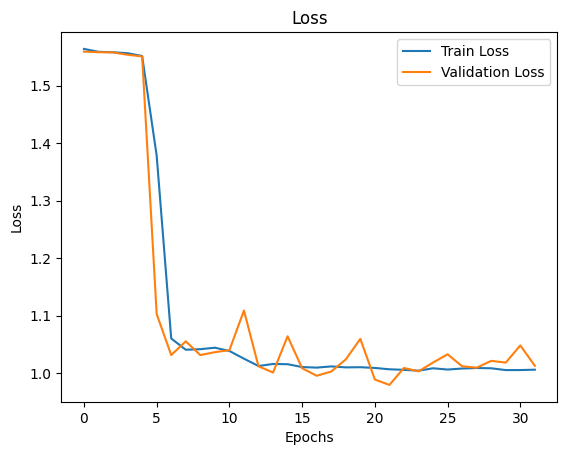

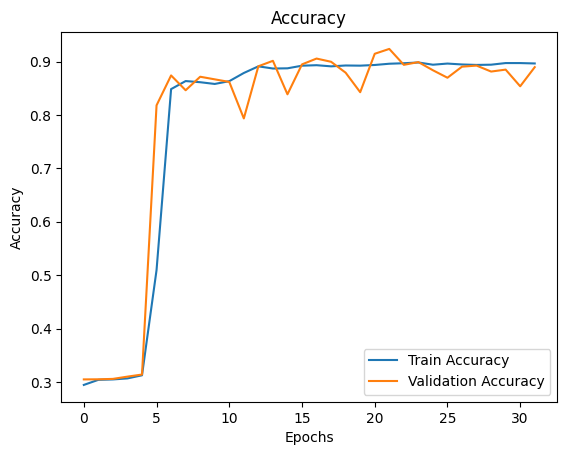

In [73]:
# 예측 및 성능 평가
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        _, labels_max = torch.max(labels.data, 1)
        y_true.extend(labels_max.cpu().numpy())

print(classification_report(y_true, y_pred))

# 손실 및 정확도 그래프
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()